# BE/Bi 103, Fall 2015: Homework 2 Solutions

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw2_solution.ipynb).*

In [16]:
# Our numerical workhorses
import numpy as np
import pandas as pd

# Import pyplot for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

### Problem 2.1 (Exploring fish sleep data, 100 pts) 

In [Tutorial 2](http://bebi103.caltech.edu/2015/tutorials/t2b_defining_and_estimating_parameters.html), we investigated sleeping states of zebrafish larvae.  We had a discussion about what are the best metrics for a sleepful versus waking states based on the one-minute interval activity data we have.  I think we agreed that it is far from obvious how to define a sleepful state.  In this problem, you will work with your group to come up with some good ways to parametrize sleep behavior and estimate the values of these parameters.

Choose three different ways to parametrize sleeping vs. wakeful states.  You can use sleep metrics from the [Prober, et al. paper](http://bebi103.caltech.edu/2014/protected/papers/prober_2006.pdf), ones we discussed in class, or invent your own.  For each of the three ways of parametrizing sleep, provide instructive plots and estimate the values of the parameters.  Compare the relative strengths and weaknesses of the sleep metrics you propose and give a discussion on which parametrization(s) you prefer.

### Problem 2.1 solution

There are many possible approaches to parametrize sleeping versus wakeful states.  Importantly, you should give good justification for your choices and provide meaningful discussion comparing the different methods.

<br />
<br />

### Problem 2.2 (Effects of the prior, 40 pts extra credit)

*This problem will be better understood after lecture on Wednesday, October 7.*

As we have seen and will continue to see in class, it is important to carefully choose the prior distribution.  However, for many parameter estimation problems where there are many data, the contribution of the prior is overwhelmed by the likelihood, so the exact functional form (within some constraints) of the prior is less important.  We will explore this computationally in this problem.

As in lecture and in [Tutorial 2b](http://bebi103.caltech.edu/2015/tutorials/t2b_defining_and_estimating_parameters.html), we will assume that the data all have errors drawn from an independent Gaussian sampling distribution with variance $\sigma^2$.  We do not assume we know what $\sigma$ is.  Our likelihood is

\begin{align}
P(D \mid \mu, \sigma, I) = \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^n
\prod_{x_i\in D} \mathrm{e}^{-(x_i - \mu)^2/2\sigma^2},
\end{align}

where $n = |D|$ is the number of points in the data set.  The posterior distribution is then

\begin{align}
P(\mu, \sigma \mid D,I) \propto P(D \mid \mu, \sigma, I)\,P(\mu, \sigma \mid I),
\end{align}

where the latter probability distribution is our prior.

I will demonstrate how to compute and plot the posterior with example fake data.  Note that it is much easier to compute

\begin{align}
\ln P(\mu, \sigma \mid D,I) = \text{constant} + \ln P(D \mid \mu, \sigma, I)
+ \ln P(\mu, \sigma \mid I)
\end{align}

because of precision issues and other reasons.  We do not really care about normalization, so we can set the constant to whatever we please to make exponentiation of the logarithm easier.  In my example, we take a prior in which $\mu$ and $\sigma$ are independent, $\mu$ is uniform on the interval $[\mu_\mathrm{min},\mu_\mathrm{max}]$ and $\sigma$ has a Jeffreys prior.  I.e.,

\begin{align}
P(\mu,\sigma \mid I) = P(\mu \mid I)\,P(\sigma \mid I) \propto \left\{
\begin{array}{cl}
\sigma^{-1} & \text{for }\mu_\mathrm{min} < \mu < \mu_\mathrm{max},\;\sigma > 0,\\[1em]
0 & \text{otherwise}.
\end{array}
\right.
\end{align}

To start the example calculation, I'll first define some handy functions for computing the posterior probability.

In [9]:
def log_prior(mu, sigma, mu_range):
    """
    Log of the unnormalized prior for a single mu and sigma with
    a Jeffreys prior for sigma and uniform prior on mu_range for mu.
    """
    if sigma < 0.0 or mu < mu_range[0] or mu > mu_range[1]:
        return -np.inf
    else:
        return -np.log(sigma)


def log_likelihood(data, mu, sigma):
    """
    Log of the unnormalized likelihood for a single mu and sigma 
    for data values data.
    """
    return -((data - mu)**2).sum() / (2 * sigma**2) - n * np.log(sigma)


def log_posterior(log_likelihood_fun, log_prior_fun, data, mu, sigma, 
                  mu_range):
    """
    Compute the log of the posterior, given an array of data, plus
    arrays of mu and sigma.  The functions defining the likelihood
    and prior are given by log_likelihood_fun and log_prior_fun, 
    respectively.
    
    Returns a 2D array of the posterior where entry i,j corresponds to
    mu[j], sigma[i].
    
    There are faster ways to calculate this, but we're doing it this way
    because we will use similar definitions when we do MCMC.
    """
    log_post = np.empty((len(sigma), len(mu)))
    for i in range(len(sigma)):
        for j in range(len(mu)):
            log_post[i, j] = log_likelihood_fun(data, mu[j], sigma[i]) \
                                + log_prior_fun(mu[j], sigma[i], mu_range)

    # Add a constant to log_post to get it close to unity so well-behaved
    # when we exponentiate it.  We don't care about normalization.
    log_post -= log_post.max()

    return log_post

    # Add a constant to log_post to get it close to unity so well-behaved
    # when we exponentiate it.  We don't care about normalization.
    log_post -= log_post.max()

    return log_post

Now that we have these functions in hand, we can cook up some fake data and compute the posterior probability.

In [10]:
# Generate 17 fake data, normally distributed with mean = std = 1.
np.random.seed(42)
real_mean = 1.0
real_std = 1.0
data = np.random.normal(real_mean, real_std, 17)

# Number of data points, for convenience
n = len(data)

# Ranges to sample parameters
mu = np.linspace(0.0, 2.0, 200)
sigma = np.linspace(0.01, 2.0, 200)

# Assume mu uniform on -1.5 < mu < 2.0
mu_range = (-1.5, 2.0)

# Compute the posterior
log_post = log_posterior(log_likelihood, log_prior, data, mu, sigma, mu_range)

Now that we can compute the posterior, we can plot it.  Since it is a function of two variables, we need to make a 3D-like plot.  Contour plots are particularly useful for this.  I like to use filled contours, which we can make using the `plt.contourf()` function.  I'll use the `'Blues'` colormap.

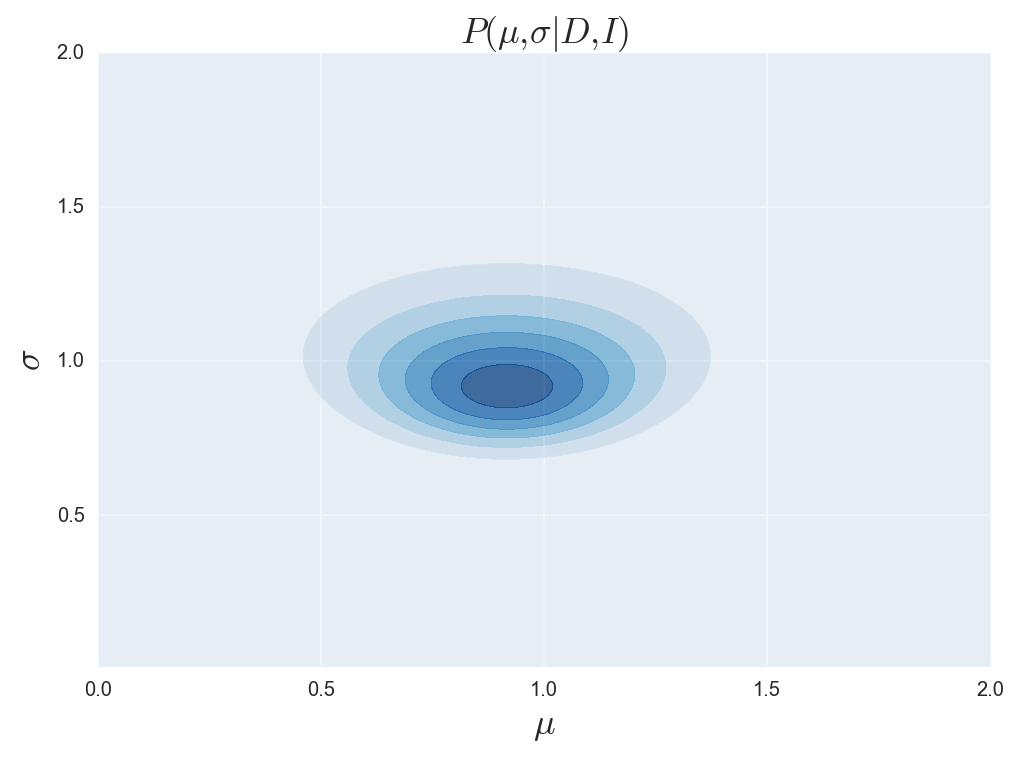

In [11]:
# Use contourf with Blues colormap.
plt.contourf(mu, sigma, np.exp(log_post), cmap=plt.cm.Blues, alpha=0.75)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title(r'$P(\mu,\sigma|D,I)$');

Another alternative is to plot $P(\mu,\sigma \mid D,I)$ as a 3D wire plot.  For this, we need to use `Axes3D` from `matplotlib`.

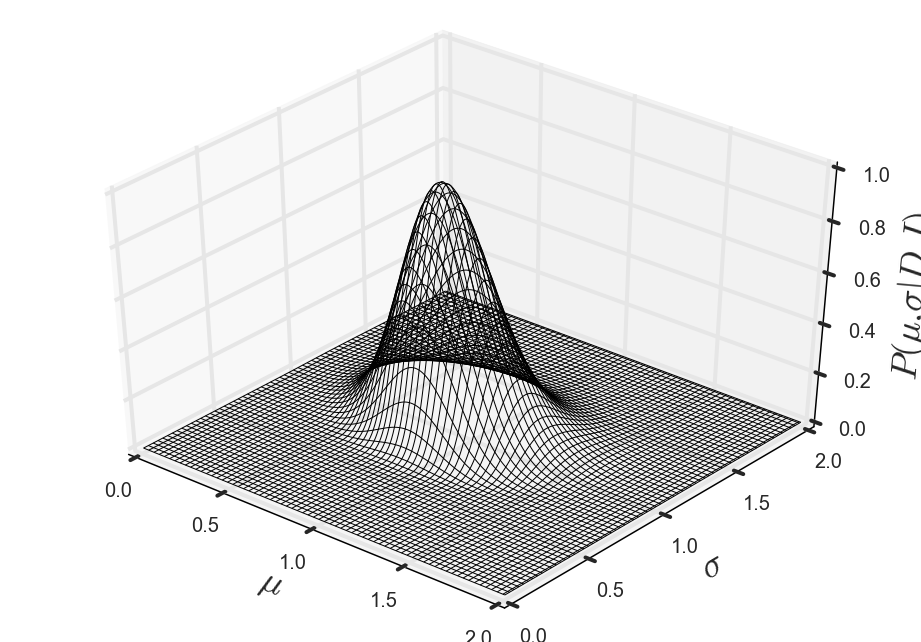

In [12]:
# Make 3D wire plot
with sns.axes_style("white"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    mmu, ssigma = np.meshgrid(mu, sigma)
    ax.plot_wireframe(mmu, ssigma, np.exp(log_post), rstride=3, cstride=3, 
                      lw=0.5)
    ax.view_init(40, -50)
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(r'$\sigma$')
    ax.set_zlabel(r'$P(\mu,\sigma|D,I)$')

(The labels being cut off are a problem only in the notebook.  If you save the figure using `plt.savefig()`, it looks fine.)  In lieu of analytically computing the most probable values of $\mu$ and $\sigma$ analytically (which is possible), we will just approximate them by the largest in our sampling.

In [13]:
# Approximate most probable value of mu and sigma
most_prob_inds = np.unravel_index(log_post.argmax(), log_post.shape)
mu_most_prob = mu[most_prob_inds[1]]
sigma_most_prob = sigma[most_prob_inds[0]]

print('most probable mu    = {0:.3f}'.format(mu_most_prob))
print('most probable sigma = {0:.3f}'.format(sigma_most_prob))

most probable mu    = 0.915
most probable sigma = 0.910


We will use data from the Gandhi, et al. data set that we analyzed in [Tutorial 2](http://bebi103.caltech.edu/2015/tutorials.html).  We will take as our data set the total minutes of activity of wild type larvae during the third night of the experiment.  This is the total number of minutes that each fish was active on that night.

**a)** Using the CSV files we made in [Tutorial 2](http://bebi103.caltech.edu/2015/tutorials/t2a_defining_and_estimating_parameters.html), generate an array (either a NumPy array or a `pandas` Series) containing the total number of sleep minutes during the third night of the experiment of each wild type fish.  This array should have 17 entries.

**b)** Compute and plot the posterior probability $P(\mu,\sigma\mid D,I)$.  Assume $\mu$ and $\sigma$ have independent priors.  Assume the prior for $\mu$ is uniform on an appropriate domain and that the prior for $\sigma$ is a Jeffreys prior ($P(\sigma\mid I) \propto \sigma^{-1})$.  Use the rough calculation method above to compute the most probable values of $\mu$ and $\sigma$.

**c)** Do the same as for part (b), except with a uniform prior for $\sigma$.  Does using a Jeffreys prior make much difference?  Whether it does or does not, why do you think this is the case?

**d)** Again assume a Jeffreys prior for $\sigma$.  Assume a Gaussian prior for $\mu$ with mean of 225 minutes and standard deviation of 150 minutes.  What effect does choosing this prior as opposed to a uniform prior have on the posterior probability?

**e)** Now assume a standard deviation of 20 minutes for the prior for $\mu$.  How is the posterior effected?

As you complete this problem, you should note that not all data you are analyzing will have the same sensitivity to prior information.  Researchers often test robustness of their results to choices of prior, and this is often a good idea.

### Problem 2.1 solution

Since we will need to approximate parameters and make plots several time, it is useful to define some functions to do that ahead of time.

In [14]:
def plot_contour(ax, mu, sigma, log_post, y_label=r'$\sigma$',
                 title_str=r'$P(\mu,\sigma|D,I)$'):
    """
    Makes a contour plot of the posterior distribution specified by its
    logarithm, log_post.
    """
    ax.contourf(mu, sigma, np.exp(log_post), cmap=plt.get_cmap('Purples_r'))
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(y_label)
    ax.set_title(title_str)
    return ax

def print_most_prob(mu, sigma, log_post):
    """
    Prints the approximate most probable values of mu and sigma to the 
    screen, given the log of the posterior, log_post.
    """
    most_prob_inds = np.unravel_index(log_post.argmax(), log_post.shape)
    mu_most_prob = mu[most_prob_inds[1]]
    sigma_most_prob = sigma[most_prob_inds[0]]
    print('most probable mu    = {0:.3f}'.format(mu_most_prob))
    print('most probable sigma = {0:.3f}'.format(sigma_most_prob))

**a)** We will load in the data from the tutorial.  Computing the total number of sleep minutes is then easily done using methods native to `pandas` DataFrames.

In [15]:
# This is the data set with the one-minute interval sleep data.
df = pd.read_csv('130315_wt.csv')

# Select nighttime data (not df.light and df.day == 2)
df = df[(~df.light) & (df.day==2)]

# Drop the columns that are not actual fish activity data
df = df.drop(['light', 'day', 'zeit'], axis=1)

# Only keep the data that are no activity
df = df[df==0.0].count(axis=0)

# We don't care about indices, so write it as a NumPy array for convenience
data = df.values.astype(float)

# Note that we could do these last four steps in a one liner:
# data = df[(~df.light) & (df.day==2)].drop(
#               ['light', 'day', 'zeit'], axis=1).sum(axis=0).values / 60.0

# Show that we got the data loaded properly
print(data)

NameError: name 'pd' is not defined

**b)** We can directly use the functions given in the problem statement to compute the posterior.  We will plot it in a similar fashion as well.

most probable mu    = 188.442
most probable sigma = 66.131


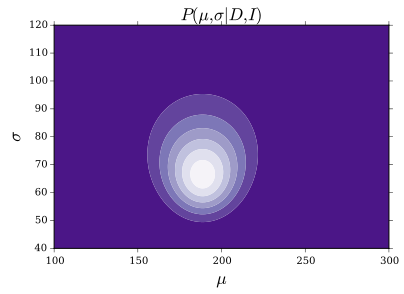

In [103]:
# Ranges to sample parameters
mu = np.linspace(100.0, 300.0, 200)
sigma = np.linspace(40.0, 120.0, 200)

# mu must be positive, and the maximal amount of inactivity is 600 minutes,
# the total duration of the night.
mu_range = (0.0, 600.0)

# Compute the posterior
log_post_partb = log_posterior(log_likelihood, log_prior, data, mu, sigma, 
                               mu_range)

# Plot the results and print to screen
fig, ax = plt.subplots()
ax = plot_contour(ax, mu, sigma, log_post_partb)
print_most_prob(mu, sigma, log_post_partb)

So, the most probably mean number of minutes slept on the third night is $\mu^* \approx 9.7$ minutes.  The most probable standard deviation is $\sigma^* = 4.0$ minutes.  Note that this standard deviation is **not** the standard error of the mean.

**c)** We first write a function to give a flat prior for $\mu$.  In the prior is a constant, it contributes an additive constant to the logarithm of the posterior.  Since we do not deal with normalization, we can arbitrarily set this constant to zero.  We can do this for both the uniform prior for $\mu$ and for $\sigma$.  I.e.,

\begin{align}
P(\mu,\sigma|I) = \text{constant} 
\;\Rightarrow\; \log P(\mu, \sigma|I) = \text{constant}
\end{align}

In [104]:
def log_prior_flat(mu, sigma, mu_range):
    """
    Log of the unnormalized prior for a single mu and sigma with
    a Jeffreys prior for sigma and uniform prior on mu_range for mu.
    """
    return 0.0

After defining the log of the prior, we can compute the posterior as before.

most probable mu    = 188.442
most probable sigma = 68.141


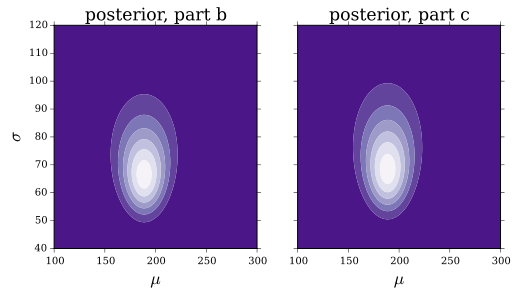

In [105]:
# Compute the posterior, this time with a flat prior
log_post = log_posterior(log_likelihood, log_prior_flat, data, mu, sigma, 
                         mu_range)

# Plot the results and print to screen
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax[0] = plot_contour(ax[0], mu, sigma, log_post_partb, 
                     title_str='posterior, part b')
ax[1] = plot_contour(ax[1], mu, sigma, log_post, y_label='',
                     title_str='posterior, part c')
print_most_prob(mu, sigma, log_post)

The most probable value for $\mu$ did not change.  We do see a shift in the most probable value for $\sigma$, though it only changed by about 2%.  The posterior distribution is very similar, with only a small shift in $\sigma$.  So, it does not seem like the Jeffreys prior matters much for the calculation of the posterior.  This can be seen by the relative contributions of each term in the logarithm of the posterior.

\begin{align}
\ln P(\mu,\sigma~|~D,I) = \text{constant} - (n+1) \ln \sigma - \sum_{i\in D}\frac{(x_i - \mu)^2}{2\sigma^2}.
\end{align}

The Jeffreys prior contributed $\log \sigma$ to the log of the posterior.  This is the "$+1$" in the $(n+1)\ln \sigma$ term.  If $n$ is large, $n+1 \approx n$, so the Jeffreys prior does not make much difference.  This is not generally true for all likelihood functions, but is often the case when the likelihood is Gaussian.

**d)** With a Gaussian prior for $\mu$, the prior is now

\begin{align}
P(\mu,\sigma~|~D,I) \propto \frac{1}{\sigma_\mu}\exp\left[-\frac{(\mu - \mu_\mathrm{prior})^2}{2\sigma_\mu}\right].
\end{align}

This gives a log prior of

\begin{align}
ln P(\mu,\sigma~|~D,I) = \text{constant} - \ln \sigma - \ln \sigma_\mu - \frac{(\mu-\mu_\mathrm{prior})^2}{2\sigma_\mu}.
\end{align}

We use this function as our log prior and proceed as before.  For part (d), we use $\mu_\mathrm{prior} = 14$ minutes and $\sigma_\mu = 10$ minutes.

most probable mu    = 212.563
most probable sigma = 70.151


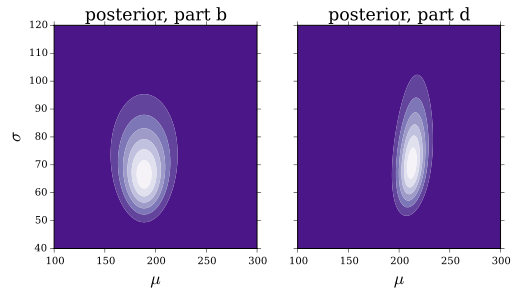

In [108]:
# We have to redine our posterior function to include extra prior
# parameters
# Define log of the posterior
def log_posterior_gaussian_prior(log_likelihood_fun, log_prior_fun, data, mu,
                                 sigma, mu_range, mu_prior, sigma_mu):
    """
    Compute the log of the posterior, given an array of data, plus
    arrays of mu and sigma.  The functions defining the likelihood
    and prior are given by log_likelihood_fun and log_prior_fun, 
    respectively.
    
    Returns a 2D array of the posterior where entry i,j corresponds to
    mu[j], sigma[i].
    
    There are faster ways to calculate this, but we're doing it this way
    because we will use similar definitions when we do MCMC.
    """
    log_post = np.empty((len(sigma), len(mu)))
    for i in range(len(sigma)):
        for j in range(len(mu)):
            log_post[i, j] = log_likelihood_fun(data, mu[j], sigma[i]) \
               + log_prior_fun(mu[j], sigma[i], mu_range, mu_prior, sigma_mu)

    # Add a constant to log_post to get it close to unity so well-behaved
    # when we exponentiate it.  We don't care about normalization.
    log_post -= log_post.max()

    return log_post

# Define the Gaussian log prior
def log_prior_gaussian(mu, sigma, mu_range, mu_prior, sigma_mu):
    """
    Log of the unnormalized prior for a single mu and sigma with
    a Jeffreys prior for sigma and uniform prior on mu_range for mu.
    """
    if sigma < 0.0 or mu < mu_range[0] or mu > mu_range[1]:
        return -np.inf
    else:
        return -np.log(sigma) - np.log(sigma_mu) \
                    - (mu - mu_prior)**2 / 2.0 / sigma_mu

# Define values of mu_prior and sigma_mu
mu_prior = 225.0
sigma_mu = 150.0
        
# Compute the posterior
log_post = log_posterior_gaussian_prior(
          log_likelihood, log_prior_gaussian, data, mu, sigma, mu_range,
          mu_prior, sigma_mu)

# Plot the results and print to screen
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax[0] = plot_contour(ax[0], mu, sigma, log_post_partb, 
                     title_str='posterior, part b')
ax[1] = plot_contour(ax[1], mu, sigma, log_post, y_label='',
                     title_str='posterior, part d')
print_most_prob(mu, sigma, log_post)

From the plot of the posterior, we see that it is skewed slightly to the right.  The prior information has influenced the result, but because $\sigma_\mu$ is large, its effect is not large.

**e)** We do precisely the same analysis as in part (d).

most probable mu    = 223.618
most probable sigma = 74.573


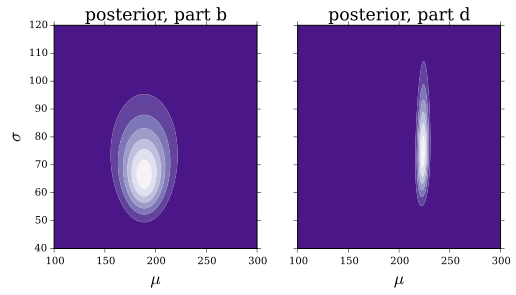

In [109]:
# Define values of mu_prior and sigma_mu
mu_prior = 225.0
sigma_mu = 15.0
        
# Compute the posterior
log_post = log_posterior_gaussian_prior(
          log_likelihood, log_prior_gaussian, data, mu, sigma, mu_range,
          mu_prior, sigma_mu)

# Plot the results and print to screen
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax[0] = plot_contour(ax[0], mu, sigma, log_post_partb, 
                     title_str='posterior, part b')
ax[1] = plot_contour(ax[1], mu, sigma, log_post, y_label='',
                     title_str='posterior, part d')
print_most_prob(mu, sigma, log_post)

Now the effect is much stronger because we were more certain with the prior, which is a bit at odds with the measured data.

<br />
<br />